In this homework, a practical example is shown for the minimum spanning tree that incorporates geometrical data. Go through this example and try to recreate it and understand it as best as you can.

We want to connect a number of buildings with landline telephone cable in the most cost effective way, where the cost depends on the length of the cable. We therefore use the minimum spanning tree to find the best cable network.

In order to complete the homework, you need to upload the building and road data to your data folder on the server. Complete the missing code in this notebook and upload your solution as a pdf file.

# Read building data

The building data is given as polygonal outlines in shapefile format and we therefore use the ogr library to read and process this data.

Make sure that all data files (e.g. buildings.shp) is stored in a folder called data.

In [1]:
import osgeo.gdal
print (osgeo.gdal.__version__)

from osgeo import ogr

from graph_tool.all import *

3.1.4


Read the buildings shapefile with the **Open()** function, which returns a dataset object.

In [2]:
filepath = r"./data/buildings.shp"

buildings_ds = ogr.Open(filepath)
    
if buildings_ds is None:
    print('Could not open {0}.'.format(filepath))
else:
    print('{0} opened successfully!'.format(filepath))

./data/buildings.shp opened successfully!


# Read road data

We will later also integrate road data in the analysis, so let's reads them in too.

In [3]:
filepath = r"./data/roads.shp"

roads_ds = ogr.Open(filepath)
    
if roads_ds is None:
    print('Could not open {0}.'.format(filepath))
else:
    print('{0} opened successfully!'.format(filepath))

./data/roads.shp opened successfully!


# Layers and Features

Extract the layer stored in each dataset.

In [4]:
buildings_layer = buildings_ds.GetLayer(0)
roads_layer = roads_ds.GetLayer(0)

print('Got layer:', buildings_layer.GetName())
print('Got layer:', roads_layer.GetName())

Got layer: buildings
Got layer: roads


You can iterate over all features of a layer in typical Python style.

In [5]:
for f in roads_layer:
    print(f)

<osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x7fd8c93b22a0> >
<osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x7fd8ec6f5930> >
<osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x7fd8c93b22a0> >
<osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x7fd8ec6f5510> >
<osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x7fd8c93b22a0> >
<osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x7fd8ec6f5930> >


Or if you additionally need an index for each feature, you can use the **enumerate()** decorator, which is a function that adds further functionality to the general iterator. Here, it extends the iterator to not only return the feature, but also a number that starts with 0 and increases with every iteration. 

In [6]:
for i, f in enumerate(roads_layer):
    print(i, f)

0 <osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x7fd8c93a2930> >
1 <osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x7fd8c9541f00> >
2 <osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x7fd8ec6f5930> >
3 <osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x7fd8ec6f5510> >
4 <osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x7fd8c9541f30> >
5 <osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x7fd8cd3197e0> >


# Convert building polygons to points

We now determine a cable connection (terminal point) for each building by finding a point inside the building's outline using the function PointOnSurface() on each building geometry. These point coordinates are stored in a NumPy array of size (2, N), where N is the number of points. (NumPy is a library that offers multi-dimensional arrays.) While doing so, we flip the y-coordinate, because the visualisation of graph-tool defines the axis in the opposite way.

In [7]:
import numpy as np

num_pts = buildings_layer.GetFeatureCount()

# construct an array of size (2, N) with zero values
pts = np.zeros((2, num_pts))

for i, f in enumerate(buildings_layer):
    geometry = f.geometry()
    pts[0, i] =  geometry.PointOnSurface().GetX()
    pts[1, i] = -geometry.PointOnSurface().GetY()

Create an undirected graph with only the vertices (no edges) for visualization and with the point coordinates as a vertex property map of type vector\<double\>. The values of this property map can be set with the **set_2d_array()** method that takes a NumPy array of size (2, N). And the property map is used in the **graph_draw()** function to draw the vertices at a given position. The drawn points are our connections for the building.

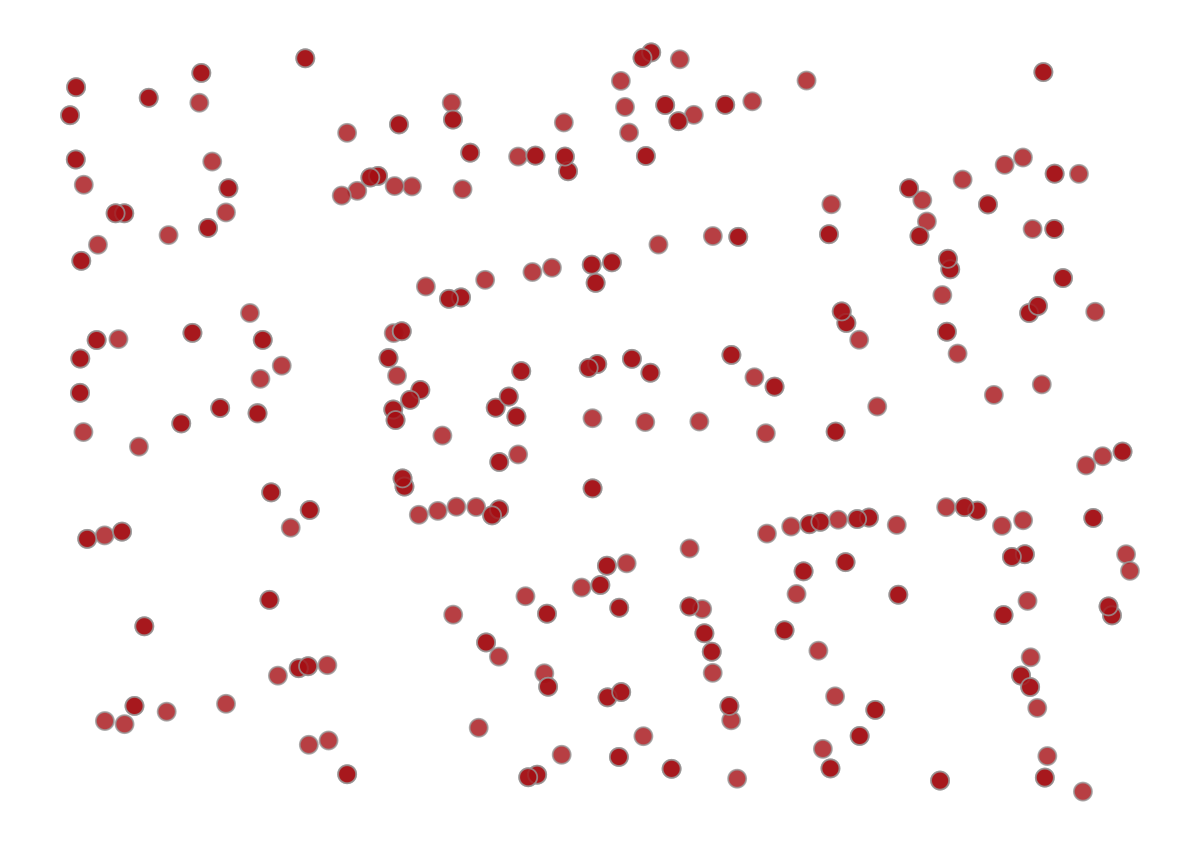

In [8]:
ug = Graph(directed=False)
ug.add_vertex(buildings_layer.GetFeatureCount())

vertex_pos_pm = ug.new_vertex_property("vector<double>")
vertex_pos_pm.set_2d_array(pts)

_ = graph_draw(ug, vertex_pos_pm)

# Connect buildings

Now, we need the possible connections between the buildings, the edges of the graph. Fortunately, graph-tool provides the **triangulation()** function that calculates a Delaunay triangulation for an array of given point coordinates. The Delaunay triangulation calculates the triangles in such a way that the smallest angle inside all the triangles is as large as possible. The connections of vertices provided by the Delaunay triangulation are also often referred to as natural neighbors.

(We have to take the transpose of the pts, as the triangulation function expects the coordinates as an array of size (N, 2).)

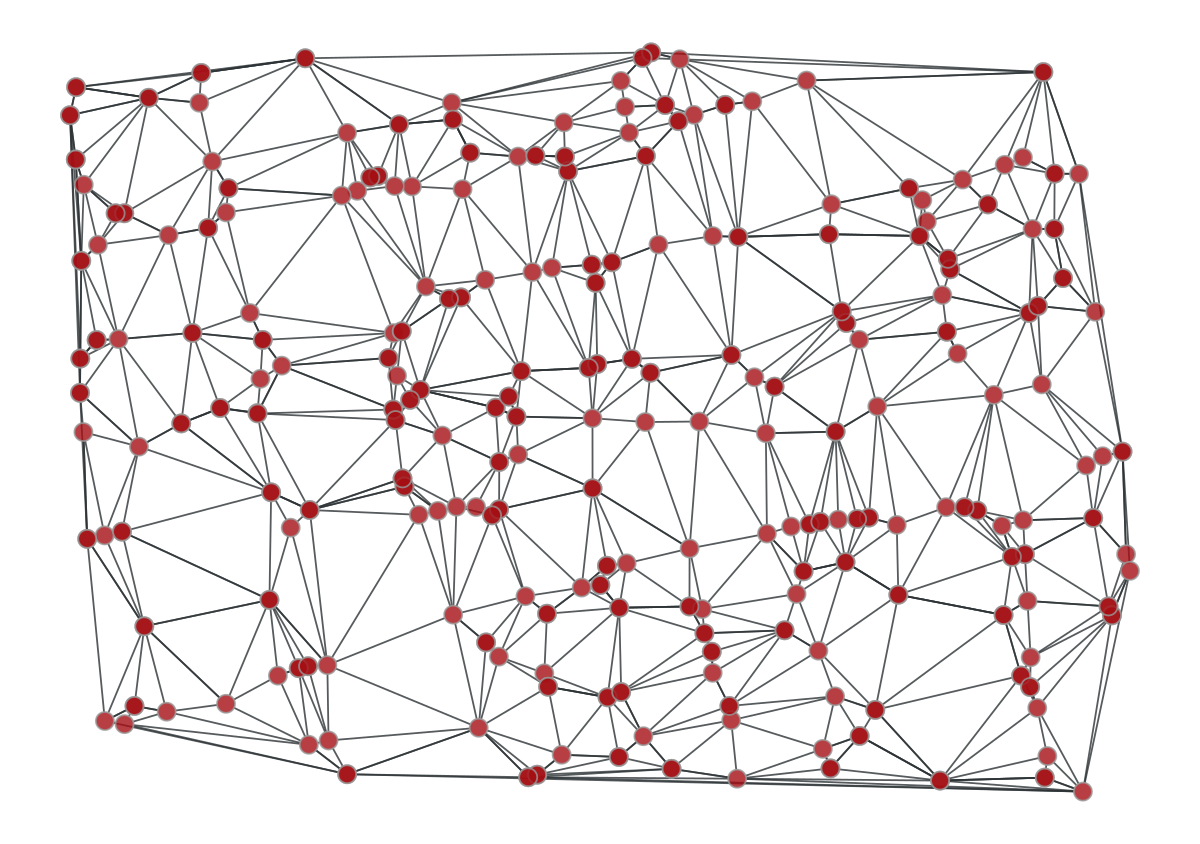

In [9]:
g, pos = triangulation(pts.transpose(), type="delaunay")

_ = graph_draw(g, pos)

# Weights

For calculating the minimum spanning tree of this graph, the weights are needed. Here, we use the Euclidean distance between the two vertices of each edge, calculated by the **norm()** function (of the linear algebra library of NumPy) on the difference of the point coordinates, and store the weights as an edge property map.

Two alternative versions are presented. 

In the first alternative, the positions returned by the triangulation() function are used. From the source and target vertex index, the coordinates are extracted with the **a()** method, which returns the underlying array of the property map. Here, for a particular point.

In the second alternative, the NumPy array that we created earlier is used and the point coordinates are just slices from this array. (You can check out slicing in Python and NumPy to get more insight into what is happening.)

Both alternative work with arrays and extract parts of arrays. If you have difficulties understanding this part, then just note that the Euclidean distance is calculated between the two vertices of each edge.

(The 2nd alternative currently overwrites the 1st alternative. If you want to see the (same) results from the 1st alternative, then put comments in front of the 2nd alternative.)

In [12]:
from numpy import linalg

weight = g.new_edge_property("double")

for e in g.edges():
    # 1st alternative working on the coordinates returned by the triangulation() function
    weight[e] = linalg.norm(pos[e.target()].a - pos[e.source()].a)
    
    # 2nd alternative working on the initial NumPy array
    weight[e] = linalg.norm(pts[:, int(e.target())] - pts[:, int(e.source())])

# Task 1
Calculate and visualize the minimum spanning tree of the previous graph

Visualize the minimum spanning tree as a graph view, which is just a view on a given graph, here with an edge filter from the minimum spanning tree.

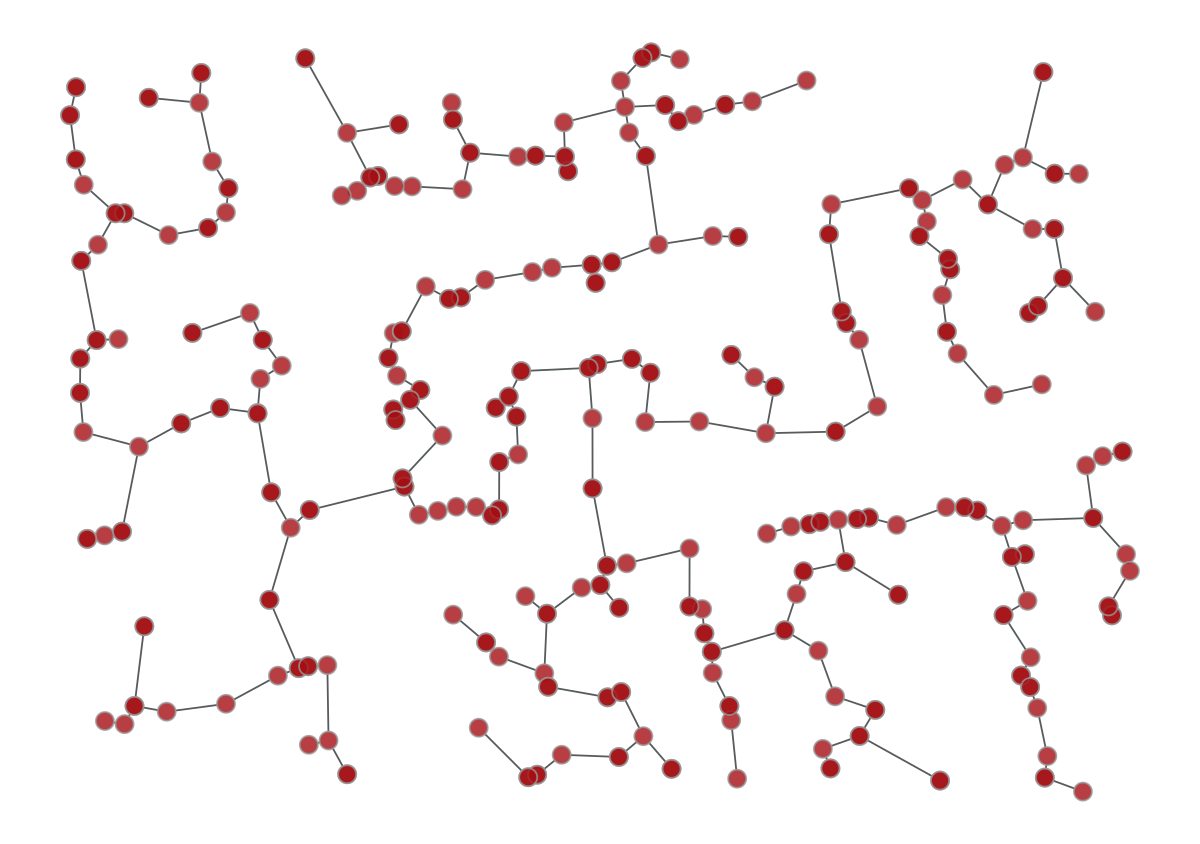

# Incorporate Roads

Let us assume that every building block shall receive its own cable connection. Therefore, the edges from the triangulation that cross a road are filtered out with an edge filter property map. The edge filter is initialized so that all values receive the Boolean value true.

Then, we loop over all the edges of the graph, convert every edge into a LineString geometry, then test the edge geometry against all road geometries. If an intersection is found between an edge and a road geometry, then the edge filter is set to false for that particular edge.

The edge filter is then used for visualization.

In [13]:
edge_filter = g.new_edge_property("bool", val=True)

for i, e in enumerate(g.edges()):
    # construct a line string geometry
    edge = ogr.Geometry(ogr.wkbLineString)
    
    # 1st alternative using pos from triangulation
    edge.AddPoint(pos[e.source()][0], -pos[e.source()][1])
    edge.AddPoint(pos[e.target()][0], -pos[e.target()][1])

    # 2nd alternative using the NumPy array
    edge.AddPoint(pts[0, int(e.source())], -pts[1, int(e.source())])
    edge.AddPoint(pts[0, int(e.target())], -pts[1, int(e.target())])
    
    # check for intersection with every road
    for r in roads_layer:
        if edge.Intersects(r.geometry()):
            edge_filter.a[i] = False
            break

# Task 2
Draw the graph that incorporates the roads

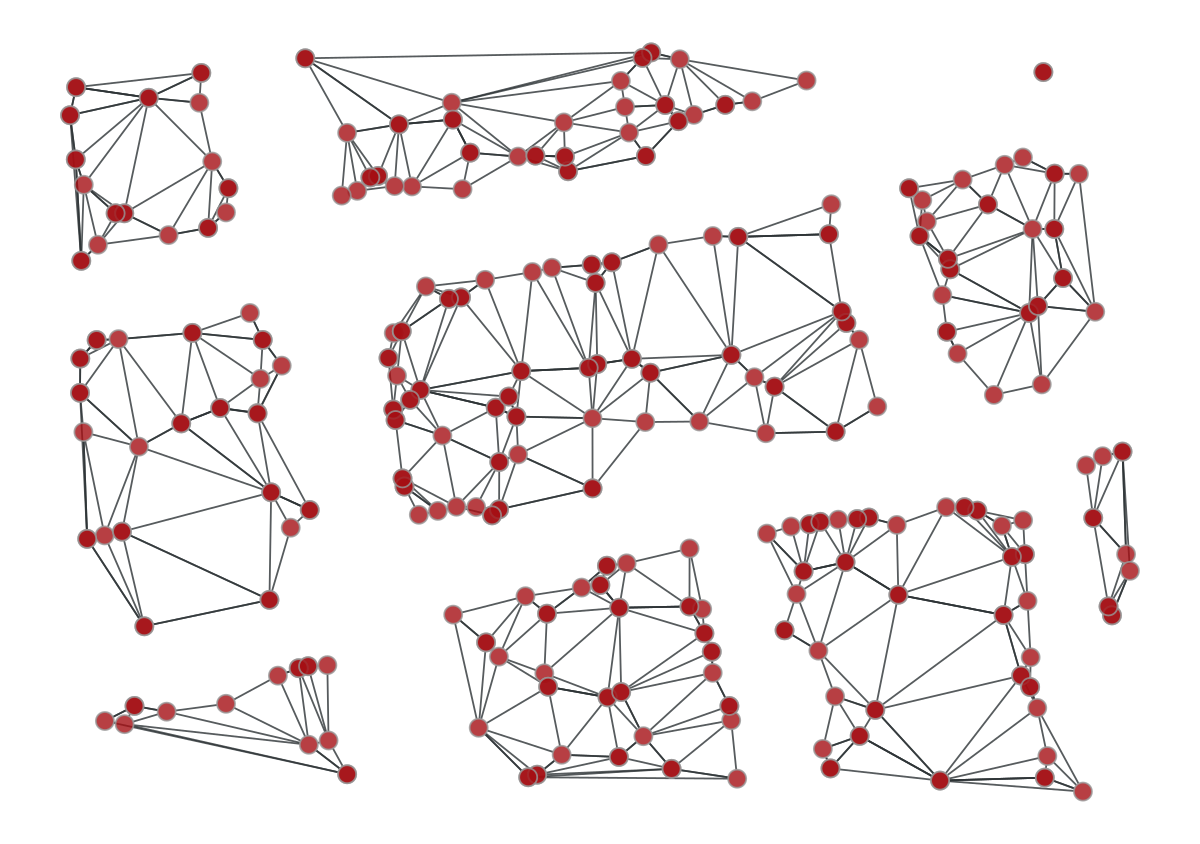

# Task 3
Calculate and visualize the minimum spanning tree for the filtered graph.

Visualize the final result.

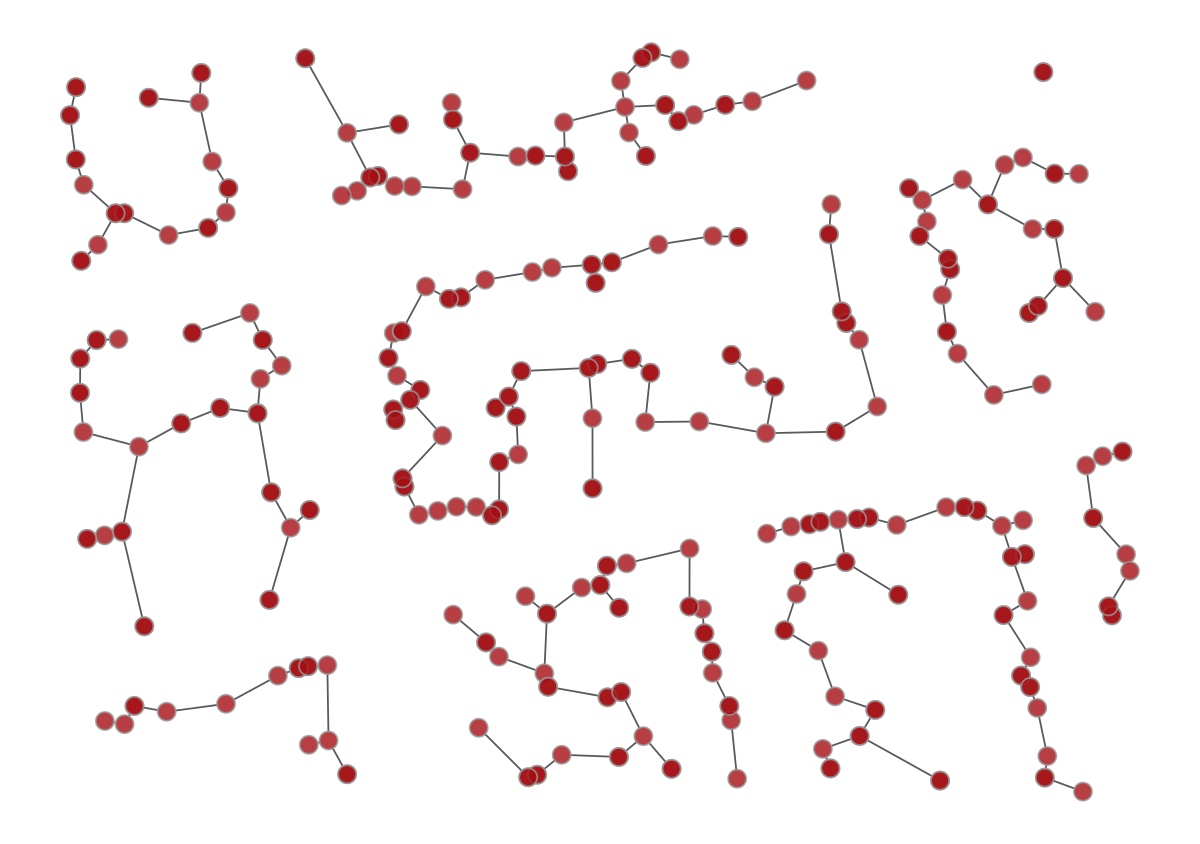